# Математические Основы Data Science и EDA

## 1 Часть

Задание: посмотреть на данные, посмотреть на названия колонок, посмотреть на типы данных для каждой колонки.
В файле clients.csv предоставленна информация о клиентах риэлторской компании США за один месяц. Вам необходимо сделать следующее:
Используя данные о выборке, постройте типичный портрет целевого клиента компании (пол, возраст, какой тип квартиры он приобретает, какова площадь в кв. м , каков средний чек, цель покупки, источник лида (колонка Source).
Таким образом результат анализа - небольшое описание нашего целевого клиента с соответствующими визуализациями

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [169]:
df = pd.read_csv('clients.csv')
df.head()

,ID,Building,Year of sale,Month of sale,Type of property,Property number,Area (ft.),Price,Status,Customer ID,Entity,Name,Surname,Age at time of purchase,Age Interval,Y,M,D,Gender,Country,State,Purpose,Deal satisfaction,Mortgage,Source
0,1030,1,2005,11,Apartment,30,743.090,"$ 246,172.68",Sold,C0028,Individual,Madalyn,Mercer,19.000,18-25,1986.000,6.000,21.000,F,USA,California,Home,5,No,Website
1,1029,1,2005,10,Apartment,29,756.210,"$ 246,331.90",Sold,C0027,Individual,Lara,Carrillo,22.000,18-25,1983.000,2.000,24.000,F,USA,California,Home,5,No,Website
2,2002,2,2007,7,Apartment,2,587.280,"$ 209,280.91",Sold,C0112,Individual,Donavan,Flowers,22.000,18-25,1985.000,12.000,27.000,M,USA,California,Home,1,Yes,Client
3,2031,2,2007,12,Apartment,31,1604.750,"$ 452,667.01",Sold,C0160,Individual,Darien,Dorsey,22.000,18-25,1985.000,12.000,27.000,M,USA,California,Investment,3,Yes,Website
4,1049,1,2004,11,Apartment,49,1375.450,"$ 467,083.31",Sold,C0014,Individual,Alessandra,Perry,25.000,18-25,1979.000,5.000,15.000,F,USA,California,Home,4,No,Agency


Посмотрим предварительно, что преставляет собой данный dataset

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       195 non-null    int64  
 1   Building                 195 non-null    int64  
 2   Year of sale             195 non-null    int64  
 3   Month of sale            195 non-null    int64  
 4   Type of property         195 non-null    object 
 5   Property number          195 non-null    int64  
 6   Area (ft.)               195 non-null    float64
 7   Price                    195 non-null    object 
 8   Status                   195 non-null    object 
 9   Customer ID              195 non-null    object 
 10  Entity                   195 non-null    object 
 11  Name                     195 non-null    object 
 12  Surname                  195 non-null    object 
 13  Age at time of purchase  178 non-null    float64
 14  Age Interval             1

In [171]:
df.rename(columns = {'Age Interval ':'Age Interval'}, inplace = True)
df.columns

Index(['ID', 'Building', 'Year of sale', 'Month of sale', 'Type of property',
       'Property number', 'Area (ft.)', 'Price', 'Status', 'Customer ID',
       'Entity', 'Name', 'Surname', 'Age at time of purchase', 'Age Interval',
       'Y', 'M', 'D', 'Gender', 'Country', 'State', 'Purpose',
       'Deal satisfaction', 'Mortgage', 'Source'],
      dtype='object')

Итого мы имеем некоторую информацию о совершенных сделках (Status = 'Sold') на рынке недвижимости. Данная информация характеризует:
* сам объект недвижимости: тип - офисная или жилая, площать, предположительно дата строительства (Y,M,D), географическое местположение (в основном, USA, но не только));
* клиент, который ее приобрел: идентификатор в базе, физическое или юридическое лицо, фамилия и имя, пол, возраст и т.д.;
* информация о собственно сделке: регистрационный номер в базе, цена, по которой продано, целевое назначение, в ипотеку либо нет.

Для построения типичного портрета целевого объекта компании нас в первую очередь интересует следующий набор колонок:
* _Type of property_ - тип приобретаемой недвижимости: Apartement (жилая) или Office (офисная);
* _Area (ft.)_ - площадь. Для перевода в m2 можно воспользоваться соотношением: 1 Square Feet = 0.093 Square Meter
* _Price_ - цена покупки
* _Entity_ - тип клиента: Individual (физичиское лицо) или Firm (юридическое лицо)
* _Age at time of purchase_ - возраст клиента на момент покупки
* _Age Interval_ - возрастной диапазон клиента
* _Gender_ - пол: M (мужской) или F (женский)
* _Purpose_ - цель покупки: Home (для проживания) или Investment (как инвестиция в недвижимость)
* _Source_ - иcточник, с помощью которого клиент узнал о компании: Agency (через агенство), Client (он или кто-то из знакомых являлись ранее клиетом), Website (через информацию, размещенную на сайте).

Выполним небольшое преобразование типов данных для интересующих нас колонок

In [172]:
df = df.astype({'Type of property':'category', 'Entity':'category', 'Name':str, 'Surname':str, 'Purpose':'category', 
               'Age Interval':'category', 'Gender':'category', 'Mortgage':'category', 'Source':'category'})

def clean_currency(x):
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

df['Price'] = df['Price'].apply(clean_currency).astype('float')

Проанализируем отсутствующие значения в массиве данных

In [173]:
print(df.isnull().sum())
df[pd.isnull(df['Gender'])]

ID                    0
Building              0
Year of sale          0
Month of sale         0
Type of property      0
                     ..
State                14
Purpose               0
Deal satisfaction     0
Mortgage              0
Source                0
Length: 25, dtype: int64


,ID,Building,Year of sale,Month of sale,Type of property,Property number,Area (ft.),Price,Status,Customer ID,Entity,Name,Surname,Age at time of purchase,Age Interval,Y,M,D,Gender,Country,State,Purpose,Deal satisfaction,Mortgage,Source
178,1005,1,2004,3,Office,5,410.710,117564.070,Sold,C0001,Firm,Kamd,Co,NaN,NaN,NaN,NaN,NaN,NaN,USA,California,Investment,5,No,Agency
179,1009,1,2004,11,Office,9,1200.820,317196.400,Sold,C0012,Firm,Bridger CAL,Co,NaN,NaN,NaN,NaN,NaN,NaN,USA,Nevada,Investment,5,No,Website
180,1009,1,2004,11,Office,10,800.960,264142.160,Sold,C0012,Firm,Bridger CAL,Co,NaN,NaN,NaN,NaN,NaN,NaN,USA,Nevada,Investment,4,No,Website
181,1011,1,2005,9,Office,11,827.870,222947.210,Sold,C0025,Firm,Abdiel,Co,NaN,NaN,NaN,NaN,NaN,NaN,USA,Nevada,Investment,5,Yes,Website
182,1007,1,2005,12,Apartment,7,775.690,250312.530,Sold,C0029,Firm,Kenyon,Co,NaN,NaN,NaN,NaN,NaN,NaN,USA,Nevada,Investment,1,Yes,Website
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,1022,1,2005,7,Apartment,22,743.090,210745.170,Sold,C0174,Firm,Marleez,Co,NaN,NaN,NaN,NaN,NaN,NaN,USA,California,Investment,5,No,Website
191,1028,1,2005,7,Apartment,28,1160.360,331154.880,Sold,C0174,Firm,Marleez,Co,NaN,NaN,NaN,NaN,NaN,NaN,USA,California,Investment,5,No,Website
192,1034,1,2005,7,Apartment,34,625.800,204434.680,Sold,C0174,Firm,Marleez,Co,NaN,NaN,NaN,NaN,NaN,NaN,USA,California,Investment,5,No,Website
193,1037,1,2005,7,Apartment,37,756.210,189194.310,Sold,C0174,Firm,Marleez,Co,NaN,NaN,NaN,NaN,NaN,NaN,USA,California,Investment,5,No,Website


Dataset содержит довольно большое количество пропущенных значений. Если присмотреться повнимательнее, то информация о поле, возрасте и пр. отсутствует тогда, когда в качестве покупателя выступает юридическое лицо (Entity = 'Firm'). Однако таких покупателей заметно меньше, чем покупателей физических лиц

In [174]:
df['Entity'].value_counts()

Individual    178
Firm           17
Name: Entity, dtype: int64

В дальшейшем для построение портрета нашего типичного покупателя сконцентируемся на физических лицах

In [175]:
df = df.loc[df['Entity']=='Individual']

In [176]:
print(df.isnull().sum())

ID                    0
Building              0
Year of sale          0
Month of sale         0
Type of property      0
                     ..
State                14
Purpose               0
Deal satisfaction     0
Mortgage              0
Source                0
Length: 25, dtype: int64


У таких клиентов для 14 записей отсутвует информация о штате расположения недвжимости (сделки вне USA), но данная информация нас сейчас не интересует, оставим неопреденные значения без изменений

### Теперь приступим непосредственно к построению портрета типичного клиента компании:

In [177]:
df['Gender'].value_counts()

M    108
F     70
Name: Gender, dtype: int64

Как видим, мужчин больше. Посмотрим теперь повнимательнее на возраст покупателей

36-45    52
46-55    41
26-35    36
56-65    26
65+      18
18-25     5
Name: Age Interval, dtype: int64


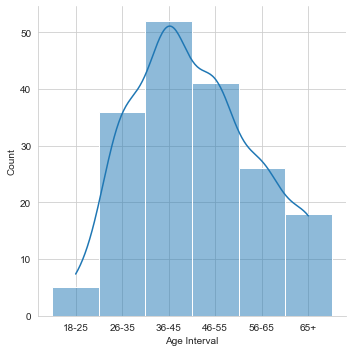

In [178]:
print(df['Age Interval'].value_counts())
sns.displot(df, x="Age Interval", kde=True);

Как видим, больше всего клиентов в возрастном интервале 36-45 лет.
Для анализа возраста у нас есть еще одна колонка "Age at time of purchase", посмотрим на нее повнимательнее

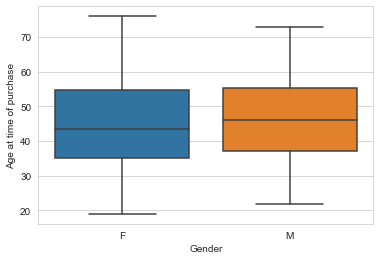

In [179]:
sns.boxplot(x="Gender", y="Age at time of purchase", data=df);

In [180]:
df.groupby('Gender')['Age at time of purchase'].mean()

Gender
F   45.157
M   46.796
Name: Age at time of purchase, dtype: float64

Как видим, мужчины-покупатели чуть постарше, но в целом возраст среднего покупателя около 45 лет.

Посмотрим, что за тип недвижимости приобретали:

In [181]:
df['Type of property'].value_counts()

Apartment    176
Office         2
Name: Type of property, dtype: int64

Даже без визуального представления очевидно, что в основном приобреталась жилая недвижимость. Посмотрим, какая у нее была площадь.

In [182]:
df['Area, m2'] = df['Area (ft.)'] * 0.092903

In [183]:
df.agg( { 'Area, m2': ['mean', 'median', 'std'], 'Area (ft.)': ['mean', 'median', 'std'] } )

,"Area, m2",Area (ft.)
mean,84.078,905.009
median,73.628,792.530
std,24.098,259.384


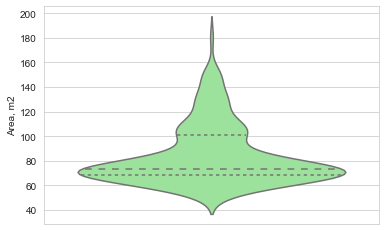

In [187]:
sns.violinplot(y='Area, m2', data=df, color="lightgreen", inner="quartile");

Как видно из приведенных выше данных, распределение площадей проданных квартир неравномерное: больше квартир продается меньшей площади, что вполне логично. При средней площади 84 м2 медианное значение ниже 80, а именно 74 м2

Следующий показатель для анализа - цена купленной квартины. Ранее мы уже перевели тип данных в необходимый числовой формат

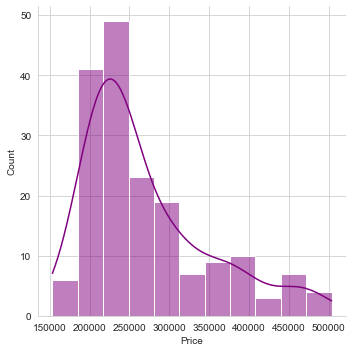

In [188]:
sns.displot(df, x="Price", kde=True, color="purple");

In [189]:
df.agg({'Price': ['mean', 'median', 'std']}).T

,mean,median,std
Price,270965.426,245196.730,78525.152


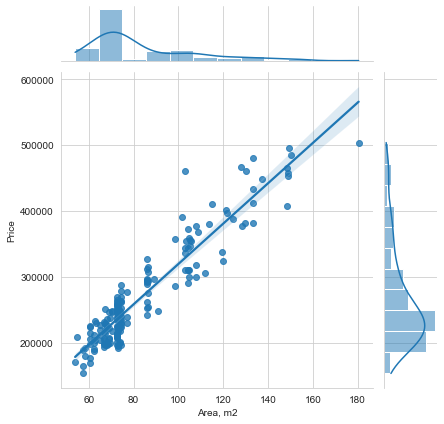

In [190]:
sns.jointplot(x='Area, m2', y='Price', 
              data=df, kind="reg");

Как видим, цена в значительной мере обусловлена площадью квартир. И также имеет асиметричное распределение: при средней цене в 270 тыс. долл. США половина квартир приобретена по цене ниже 245 тыс. долл. США

In [191]:
df['Purpose'].value_counts()

Home          118
Investment     60
Name: Purpose, dtype: int64

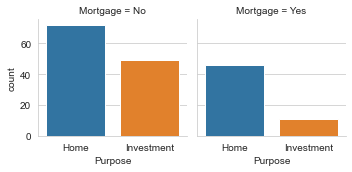

In [193]:
sns.catplot(x="Purpose", col="Mortgage", data=df, kind="count", height=2.5);

Как видим, большая часть приоретенных квартир приобреталась для собственного проживания, а не в качестве объекта для инвестиций. Причем по большей части они приобретены не в ипотеку, т.е. без залога недвижимости.

Источником лида в нашем случае является Website:

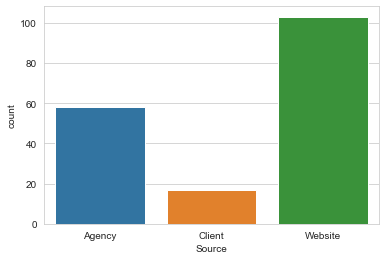

In [196]:
sns.countplot(x="Source", data=df);

In [197]:
df['Source'].value_counts()

Website    103
Agency      58
Client      17
Name: Source, dtype: int64

### Таким образом, целевой клиент выглядит следующим образом: это преимущественно мужчина в возрасте примерно 45 лет, который, самостоятельно находя информацию в сети о Компании и регистрируясь на сайте, приобретает без ипотеки квартиру в США для проживания площадью порядка 80 квадратных метров и стоимостью около 250 тыс. долл. США